# PyOAE - Mitigation of OA indicator variables using OAE
**Calculation of the amount of OAE addition of TA needed to restore current ocean conditions to pre-industrial for OA indicator variables in the global oceans**

by Greg Pelletier, 12-Mar-2025

This notebook presents a new method to calculate the amount of Ocean Alkalinity Enhancement (OAE) addition of total alkalinity (TA) that is needed to restore the current untreated condtions (e.g. in year 2010) to the same condition as were present in pre-industrial times (e.g. year 1750), for a selected Ocean Acidification (OA) indicator variable (e.g. TA-DIC, CO3--, Ωara, Ωcal, or pH).   

The difference between TA and DIC, also known as Alk* (Sarmiento & Gruber, 2006), can be used as a surrogate variable to interpret the response of other carbonate system variables (e.g. CO3--, pH, Ωara, Ωcal), and also interpret the response of calcification to OA and OAE (Xue & Cai, 2020). Ocean acidification has caused a decrease in TA-DIC since pre-industrial conditions (Sarmiento & Gruber, 2006). 

The question we attempt to address in ths notebook is stated as follows: 

- What is the quantity of OAE required to restore the recent historical OA indicators (e.g. TA-DIC, CO3--, pH, Ωara, Ωcal) to pre-industrial conditions? 

In this notebook we present a root-finding method to solve for the OAE treatment to restore any carbonate system variable (e.g. TA-DIC, CO3--, pH, Ωar, etc.) to pre-industrial conditions. The advantage of the root-finding method is that it can be used to solve for the OAE treatment required for restoration of any carbonate system variable with excellent precision. The disadvantage of the root-finding method is that it takes several hours of CPU time to solve for a water layer over the entire global ocean grid at a spatial resolution of 1$^\circ$ x 1$^\circ$.

A "root-finding method" is a mathematical technique used to determine the values of a variable (e.g. the OAE treatment ΔTA) that make a given function equal to zero, essentially finding the "root" or "zero" of that function. This is done through an iterative numerical algorithm when analytical solutions are not readily available. In this project we use Brent’s method for the numerical algorithm as implemented in the scipy optimize brentq function.

The general formula for the root-finding method with brentq is as follows, as brentq tries to find a point x where fun(x) = 0 using Brent’s method:

x = scipy.optimize.brentq(fun, x_lwr, x_upr)		

where

-  x = the root of the OAE treatment ΔTA (µmol kg-1) such that the the result of the function ‘fun’ is equal to zero
- fun = the function that calculates the difference between the treated condition at time t (e.g. year 2010 afer hypothetical OAE treatment) compared with the pre-industrial condition (e.g. year 1750) for whichever objective variable is being evaluated (e.g. TA-DIC, CO3--, pH, Ωar).
-  x_lwr = lower bound range of the OAE treatment ΔTA (µmol kg-1).
-  x_upr = upper bound range of the OAE treatment ΔTA (µmol kg-1).

The function ‘fun’ determines the difference between the treated condition at time t (e.g. year 2010 after hypothetical OAE treatment) compared with the pre-industrial condition (e.g. year 1750) for whichever objective variable is being evaluated (e.g. TA-DIC, CO3--, pH, Ωara, Ωcal) as follows:

fun(x) = y_t,trt – y_PI	

where

-  y_t,trt = the value objective variable at time t (e.g. 2010) after hypothetical OAE treatment
-  y_PI = the value of the objective variable in pre-industrial conditions (e.g. 1750)
-  y = the carbonate system variable that is used as the objective variable (e.g. TA-DIC, CO3--, pH, Ωara, Ωcal).

The function ‘fun’ performs the following calculations using CO2SYS and the equations:

-	Calculate ΔDICtrt and ΔDICcdr from trial values of x = dTA = ΔTAtrt using the following equations:

    - ΔTAtrt = dTA = x = the trial value of the hypothetical OAE treatment addition of total alkalinity (umol/kg)
    - ΔDICtrt = direct chemical addition of DIC due to the trial value of the OAE treatment addition (umol/kg)
    - ΔDICcdr = indirect CDR addition of DIC in response to the OAE treatment addition (umol/kg)
    - TAt,ctl = control TA at time t before OAE treatment (umol/kg)
    - TAt,trt = TAt,ctl + dTA = treatment TA at time t after OAE treatment (umol/kg)
    - DICt,ctl = control DIC at time t before OAE treatment (umol/kg)
    - DICt,trt = treatment DIC at time t after OAE treatment (umol/kg)
    - pCO2t,ctl = control pCO2 at time t before OAE treatment (uatm)

    - DICeq = CO2SYS calculation of DIC at equilibrium when input TA = TAt,trt and input pCO2 = pCO2t,ctl
    - CDRpot = DICeq - DICt,ctl = hypothetical maximum potential CDR (umol/kg)
    - etamax = CDRpot / dTA = hypothetical maximum OAE efficiency, typically in the range of 0.7-0.9 (dimensionless)
    - eta(t) = CDR / dTA = realized OAE efficiency at  time t due to the realized CDR (dimensionless)
    - CDReff = eta(t) / etamax = realized CDR efficiency (dimensionless)  

    - If NaOH is used for OAE, then the following equations apply:
        - ΔDICtrt = 0
        - ΔDICcdr = CDReff * etamax * dTA
    - If Na2CO3 is used for OAE, then the following equations apply:
        - ΔDICtrt = 0.5 * dTA
        - ΔDICcdr = cdreff * (etamax - 0.5) * dTA

-	Calculate the DICt,trt and TAt,trt at time t (2010) after OAE treatment as follows:
    - TAt,trt = TAt,ctl + dTA
    - DICt,trt = DICt,ctl + ΔDICtrt + ΔDICcdr
-	Calculate yt,trt corresponding to DICt,trt and TAt,trt
-	Calculate yPI corresponding to DICPI and TAPI
-	Calculate fun(x) = yt,trt – yPI


# Calculations

First we will import the python packages we need to use and read the netcdf file data we will use in this example.

The netcdf file "jiang_data_for_jupyter_v12.nc" is available to download from this github repository. This data set provides the decadal average global carbonate system variable values in the year 2010 and in the year 1750. The original source of these data is from Jiang et al (2023) (https://doi.org/10.1029/2022MS003563)

In [1]:
# import the packages that are needed
import scipy.optimize as opt
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from PyOAE import f_dTA
import time
import multiprocessing
import scipy.io
# read the global arrays of surface ocean data and assign to a dictionary
ds = xr.open_dataset("jiang_data_for_jupyter_v12.nc", chunks={"lon":60})
# copy the dask 2d arrays in ds values to numpy 2d arrays in ds_dict
ds_dict = {var: ds[var].values for var in ds.data_vars}
# Reshape all 2D arrays to 1D
ds_dict_1d = {key: arr.flatten() for key, arr in ds_dict.items()}
# initialize 1d array of the dTA_root values
ds_dict_1d["dTA_root"] = np.full((180*360), np.nan) # init out array 

Next we will specify the following options to use in this example:

- obj_var is the objective variable that we want to restore from current conditions (2010) to pre-industrial conditions (1750). This can be any of the following choices:
    - "alkstar" is TA-DIC
    - "co3" is carbonate
    - "phtot" is pH (total)
    - "omara" is aragonite saturation state omega
    - "omcal" is calcite saturation state omega
- oae_type is the chemical to be used for adding TAm either "NaOH" or "Na2CO3"
- cdreff is the CDR efficiency (a value between 0 and 1, e.g. 0.8 is 80% CDR efficiency)
- x_lwr is the lower bound of possible dTA values (umol/kg)
- x_upr is the lower bound of possible dTA values (umol/kg)

In [ ]:
# specify the options to use for this example
obj_var = 'alkstar'   # objective variable: 'alkstar', 'co3', phtot', 'omara', 'omcal'
oae_type = 'NaOH'     # chemical used for OAE: 'NaOH' or 'Na2CO3'
cdreff = 0.8          # CDR efficiency between 0-1 (e.g. 0.8 = 80%)
x_lwr = 0             # lower bound of possible dTA values (umol/kg)
x_upr = 500           # upper bound of possible dTA values (umol/kg)

Next we will define the function that will be used to find the root value in each grid cell

In [2]:
# define the function to find the root in each grid cell i
def find_root(i):
    chem_pi = np.full(7, np.nan)
    chem_pi[0] = ds_dict_1d["talk_1750"][i]    # TA in 1750 (umol/kg)
    chem_pi[1] = ds_dict_1d["dic_1750"][i]     # DIC in 1750 (umol/kg)
    chem_pi[2] = ds_dict_1d["sio3"][i]         # SiO3 in 1750 (umol/kg)
    chem_pi[3] = ds_dict_1d["po4"][i]          # PO4 in 1750 (umol/kg)
    chem_pi[4] = ds_dict_1d["temp_1750"][i]    # Temperature in 1750 (degC)
    chem_pi[5] = ds_dict_1d["sal_1750"][i]     # Salinity in 1750 (psu)        
    chem_pi[6] = 0
    chem_ctl = np.full(7, np.nan)
    chem_ctl[0] = ds_dict_1d["talk_2010"][i]   # TA in 2010 (umol/kg)
    chem_ctl[1] = ds_dict_1d["dic_2010"][i]    # DIC in 2010 (umol/kg)
    chem_ctl[2] = ds_dict_1d["sio3"][i]        # SiO3 in 2010 (umol/kg)
    chem_ctl[3] = ds_dict_1d["po4"][i]         # PO4 in 2010 (umol/kg)
    chem_ctl[4] = ds_dict_1d["temp_2010"][i]   # Temperature in 2010 (degC)
    chem_ctl[5] = ds_dict_1d["sal_2010"][i]    # Salinity in 2010 (psu) 
    chem_ctl[6] = 0
    kwargs = {
    'chem_pi': chem_pi,
    'chem_ctl': chem_ctl,
    'oae_type': oae_type,
    'obj_var': obj_var,
    'cdreff': cdreff
    }
    nnn_pi = np.count_nonzero(~np.isnan(chem_pi))  # number of non-nan
    nnn_ctl = np.count_nonzero(~np.isnan(chem_ctl))  # number of non-nan
    if nnn_pi==7 and nnn_ctl==7:
        f_x = lambda x: f_dTA(x, **kwargs)
        root = opt.brentq(f_x, x_lwr, x_upr)
        return np.array([i,root])

Next we will define a matlab-style tic toc timer to measure how long the computations take

In [3]:
# matlab-style tic toc timer
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
    return

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

Next we will run the multiprocessing loop to calculate the results in all of the grid cells. This takes about 2.4 hours using 6 CPU cores.

In [4]:
# parallel processing loop through all grid cells (takes about 2.4 hours using 6 CPUs)
tic()
ncpu = 6   # number of CPU cores to use for parallel processing
with multiprocessing.Pool(processes=ncpu) as pool:    
    # Use imap_unordered to apply the function to a range of numbers
    results = pool.imap_unordered(find_root, range(ds_dict_1d["dTA_root"].shape[0]))    
    # Iterate over the results as they become available
    for result in results:
        if result is not None:
            i = int(result[0])
            root = result[1]
            ds_dict_1d["dTA_root"][i] = root
            # print(i, root) 
toc()
# reshape 1d dTA_root to 2d (180, 360)
ds_dict["dTA_root"] = ds_dict_1d["dTA_root"].reshape(ds_dict["talk_1750"].shape)

Elapsed time: 8687.132699 seconds.



Next we will make a map showing the results

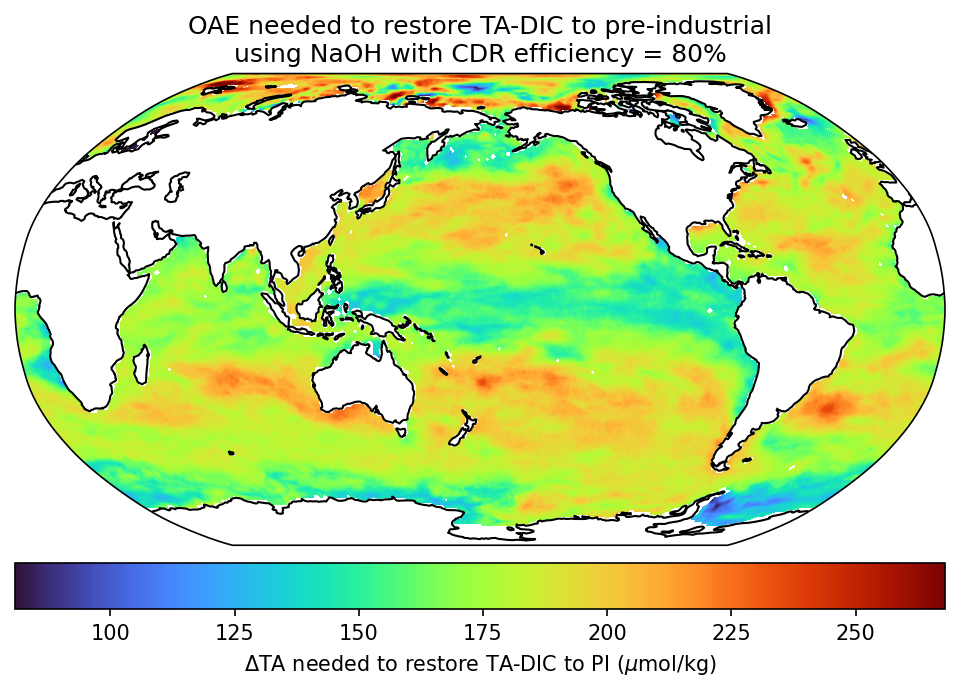

In [5]:
# Robinson map of the results
import cartopy.crs as ccrs
plt.figure(figsize=(8, 5),dpi=150)
X = np.linspace(0.5, 359.5, 360)
Y = np.linspace(-89.5, 89.5, 180)
Z = np.abs(ds_dict["dTA_root"]).copy()
zmin = np.nanpercentile(Z,0.1)
zmax = np.nanpercentile(Z,99.9)
Z[Z<zmin]=zmin
Z[Z>zmax]=zmax
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
# ax.gridlines()
plt.title('OAE needed to restore TA-DIC to pre-industrial\nusing NaOH with CDR efficiency = 80%')
plt.contourf(X,Y,Z,cmap='turbo',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label=r'$\Delta$TA needed to restore TA-DIC to PI ($\mu$mol/kg)',
            ticks=[0,25,50,75,100,125,150,175,200,225,250]);
plt.savefig('OAE_needed_for_OA_global_NaOH_CDReff80.png', format='png', dpi=300)
plt.show()

Finally we will save the results in a mat file for use later if needed

In [9]:
# save ds_dict as a mat file
scipy.io.savemat('OAE_needed_for_OA_NaOH_CDReff80_v20250311.mat', ds_dict)